In [1]:
import os
import numpy as np
import pandas as pd
import swifter
import warnings
from loguru import logger

from exonamd.catalog import download_nasa_confirmed_planets
from exonamd.utils import ROOT
from exonamd.utils import fetch_aliases
from exonamd.utils import update_host
from exonamd.utils import update_planet
from exonamd.utils import check_name
from exonamd.solve import solve_values
from exonamd.interp import interp_eccentricity
from exonamd.interp import interp_mass
from exonamd.interp import interp_inclination
from exonamd.interp import interp_sma
from exonamd.solve import solve_relincl
from exonamd.interp import interp_trueobliq
from exonamd.utils import groupby_apply_merge
from exonamd.solve import solve_namd
from exonamd.solve import solve_namd_mc
from exonamd.plot import simple_plot
from exonamd.plot import pop_plot


warnings.filterwarnings("ignore")
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
swifter.set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=False,
)

/home/ariel/andrea.bocchieri/.local/lib/python3.10/site-packages/pytools/persistent_dict.py:59: UserWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv(
    os.path.join('../exonamd', "data", "custom_db_20241012.csv"),
)

### Task 3: computing missing values (if any) from simple relations


In [4]:
logger.info("Computing missing values from simple relations")
df[
    [
        "pl_orbsmax",
        "pl_ratdor",
        "st_rad",
        "pl_rade",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ]
] = df.swifter.apply(solve_values, axis=1)
logger.info("Missing values computed")

2024-10-12 22:56:06.800 | INFO     | __main__:<module>:1 - Computing missing values from simple relations


Pandas Apply:   0%|          | 0/34 [00:00<?, ?it/s]

2024-10-12 22:56:06.858 | INFO     | __main__:<module>:13 - Missing values computed


### Task 4: storing the curated database


Drop columns that are no longer needed


In [5]:
logger.debug("Dropping columns that are no longer needed")
df.drop(
    columns=[
        "pl_ratdor",
        "st_rad",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ],
    inplace=True,
)
logger.debug("Columns dropped")

2024-10-12 22:56:06.938 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2024-10-12 22:56:06.940 | DEBUG    | __main__:<module>:12 - Columns dropped


In [6]:
logger.info("Storing the curated database")

out_path = os.path.join(ROOT, "data", "exo_custom_db_20241012.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-10-12 22:56:06.995 | INFO     | __main__:<module>:1 - Storing the curated database
2024-10-12 22:56:07.000 | INFO     | __main__:<module>:5 - Database stored at /export/NAS/ariel/users/andrea.bocchieri/.local/lib/python3.10/site-packages/exonamd/data/exo_custom_db_20241012.csv


### Task 5: input missing values (if any) by interpolation


Use nanmedian to thin down the data


In [7]:
logger.info("Thinning down the data with nanmedian")
cols = df.columns.difference(["hostname", "pl_name", "default_flag", "rowupdate"])
medians = df.groupby("pl_name")[cols].transform(np.nanmedian)
df.loc[df["default_flag"] == 1, cols] = medians.loc[df["default_flag"] == 1]
df = df[df["default_flag"] == 1].drop(columns="default_flag")
logger.info("Data thinned down")

2024-10-12 22:56:07.065 | INFO     | __main__:<module>:1 - Thinning down the data with nanmedian
2024-10-12 22:56:07.077 | INFO     | __main__:<module>:6 - Data thinned down


Check presence of duplicates (if any)


In [8]:
logger.info("Checking for duplicates")
dp = df[df.duplicated(subset=["hostname", "pl_name"], keep=False)].sort_values(
    by=["hostname", "pl_name"]
)

if len(dp) > 0:
    logger.error(f"Duplicated rows for {dp['hostname'].unique()}")
    raise ValueError(f"Duplicated rows for {dp['hostname'].unique()}")
logger.info("No duplicates found")

2024-10-12 22:56:07.157 | INFO     | __main__:<module>:1 - Checking for duplicates
2024-10-12 22:56:07.162 | INFO     | __main__:<module>:9 - No duplicates found


Instantiate flags


In [9]:
logger.info("Instantiating the flags")
df["flag"] = "0"
logger.info("Flags instantiated")

2024-10-12 22:56:07.222 | INFO     | __main__:<module>:1 - Instantiating the flags
2024-10-12 22:56:07.224 | INFO     | __main__:<module>:3 - Flags instantiated


Solve missing eccentricity values


In [10]:
logger.info("Interpolating missing eccentricity values")
df[
    [
        "pl_orbeccen",
        "pl_orbeccenerr1",
        "pl_orbeccenerr2",
        "flag",
    ]
] = df.swifter.apply(interp_eccentricity, axis=1)
logger.info("Values interpolated")

2024-10-12 22:56:07.277 | INFO     | __main__:<module>:1 - Interpolating missing eccentricity values


Pandas Apply:   0%|          | 0/34 [00:00<?, ?it/s]

2024-10-12 22:56:07.309 | INFO     | __main__:<module>:10 - Values interpolated


Solve missing planetary mass values


In [11]:
logger.info("Interpolating missing planetary mass values")
df[
    [
        "pl_bmasse",
        "pl_bmasseerr1",
        "pl_bmasseerr2",
        "flag",
    ]
] = df.swifter.apply(interp_mass, axis=1)
logger.info("Values interpolated")

2024-10-12 22:56:07.362 | INFO     | __main__:<module>:1 - Interpolating missing planetary mass values


Pandas Apply:   0%|          | 0/34 [00:00<?, ?it/s]

2024-10-12 22:56:08.085 | INFO     | __main__:<module>:10 - Values interpolated


Drop columns that are no longer needed


In [12]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_rade", "pl_radeerr1", "pl_radeerr2"], inplace=True)
logger.debug("Columns dropped")

2024-10-12 22:56:08.142 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2024-10-12 22:56:08.145 | DEBUG    | __main__:<module>:3 - Columns dropped


Remove systems where at least one planet has no mass or semi-major axis (if any)


In [13]:
logger.info("Removing systems where at least one planet has no mass or semi-major axis")
mask = (
    df.groupby("hostname")[["pl_bmasse", "pl_orbsmax"]]
    .transform(lambda x: x.isnull().any())
    .any(axis=1)
)
rm_systems = df[mask]["hostname"].unique()
logger.info(f"Removing {len(rm_systems)} systems: {rm_systems}")
df = df[~mask]
logger.info("Systems removed")

2024-10-12 22:56:08.199 | INFO     | __main__:<module>:1 - Removing systems where at least one planet has no mass or semi-major axis
2024-10-12 22:56:08.211 | INFO     | __main__:<module>:8 - Removing 0 systems: []
2024-10-12 22:56:08.212 | INFO     | __main__:<module>:10 - Systems removed


Solve missing values in inclinations


In [14]:
logger.info("Interpolating missing values in inclinations")
df[
    [
        "pl_orbincl",
        "pl_orbinclerr1",
        "pl_orbinclerr2",
        "flag",
    ]
] = df.swifter.apply(interp_inclination, args=(df,), axis=1)
logger.info("Values interpolated")

2024-10-12 22:56:08.300 | INFO     | __main__:<module>:1 - Interpolating missing values in inclinations


Pandas Apply:   0%|          | 0/34 [00:00<?, ?it/s]

2024-10-12 22:56:08.374 | INFO     | __main__:<module>:10 - Values interpolated


Interpolate missing values in semi-major axis uncertainties


In [15]:
logger.info("Interpolating missing values in semi-major axis uncertainties")
df[
    [
        "pl_orbsmaxerr1",
        "pl_orbsmaxerr2",
        "flag",
    ]
] = df.swifter.apply(interp_sma, axis=1)
logger.info("Values interpolated")

2024-10-12 22:56:08.432 | INFO     | __main__:<module>:1 - Interpolating missing values in semi-major axis uncertainties


Pandas Apply:   0%|          | 0/34 [00:00<?, ?it/s]

2024-10-12 22:56:08.463 | INFO     | __main__:<module>:9 - Values interpolated


### Task 6: compute the parameters for the NAMD calculation


Compute the relative inclination


In [16]:
logger.info("Computing the relative inclinations")
df[
    [
        "pl_relincl",
        "pl_relinclerr1",
        "pl_relinclerr2",
    ]
] = df.swifter.apply(solve_relincl, args=(df,), axis=1)
logger.info("Values computed")

2024-10-12 22:56:08.518 | INFO     | __main__:<module>:1 - Computing the relative inclinations


Pandas Apply:   0%|          | 0/34 [00:00<?, ?it/s]

2024-10-12 22:56:08.587 | INFO     | __main__:<module>:9 - Values computed


Interpolate missing values in true obliquity


In [17]:
logger.info("Interpolating missing values in true obliquity")
df[
    [
        "pl_trueobliq",
        "pl_trueobliqerr1",
        "pl_trueobliqerr2",
        "flag",
    ]
] = df.swifter.apply(interp_trueobliq, args=(df,), axis=1)
logger.info("Values interpolated")

2024-10-12 22:56:08.720 | INFO     | __main__:<module>:1 - Interpolating missing values in true obliquity


Pandas Apply:   0%|          | 0/34 [00:00<?, ?it/s]

2024-10-12 22:56:08.816 | INFO     | __main__:<module>:10 - Values interpolated


### Task 7: storing the curated+interpolated database


In [18]:
logger.info("Storing the curated+interpolated database")
out_path = os.path.join(ROOT, "data", "exo_interp_custom_db_20241012.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-10-12 22:56:08.877 | INFO     | __main__:<module>:1 - Storing the curated+interpolated database
2024-10-12 22:56:08.881 | INFO     | __main__:<module>:4 - Database stored at /export/NAS/ariel/users/andrea.bocchieri/.local/lib/python3.10/site-packages/exonamd/data/exo_interp_custom_db_20241012.csv


In [19]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo_interp_custom_db_20241012.csv"))

### Task 8: computing the NAMD


Drop columns that are no longer needed

In [20]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_orbincl", "pl_orbinclerr1", "pl_orbinclerr2"], inplace=True)
logger.debug("Columns dropped")

2024-10-12 22:56:09.037 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2024-10-12 22:56:09.040 | DEBUG    | __main__:<module>:3 - Columns dropped


Solve the relative and absolute namd


In [21]:
logger.info("Computing the relative NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="rel",
    allow_overwrite=True,
)
logger.info("Relative NAMD computed")

2024-10-12 22:56:09.142 | INFO     | __main__:<module>:1 - Computing the relative NAMD
2024-10-12 22:56:09.174 | INFO     | __main__:<module>:9 - Relative NAMD computed


In [22]:
logger.info("Computing the absolute NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="abs",
    allow_overwrite=True,
)
logger.info("Absolute NAMD computed")

2024-10-12 22:56:09.297 | INFO     | __main__:<module>:1 - Computing the absolute NAMD
2024-10-12 22:56:09.328 | INFO     | __main__:<module>:9 - Absolute NAMD computed


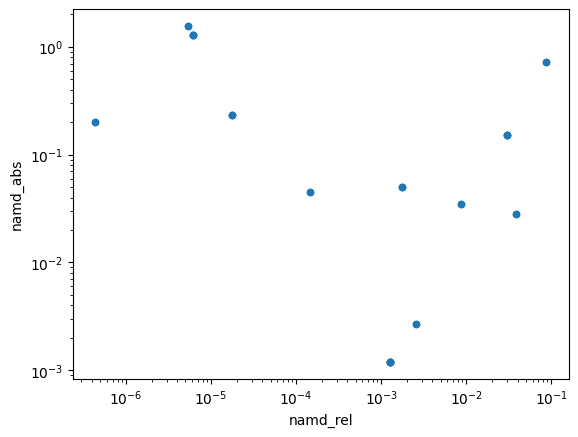

In [23]:
_ = (
    df.groupby("hostname")[["namd_rel", "namd_abs"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel", y="namd_abs", loglog=True)
)

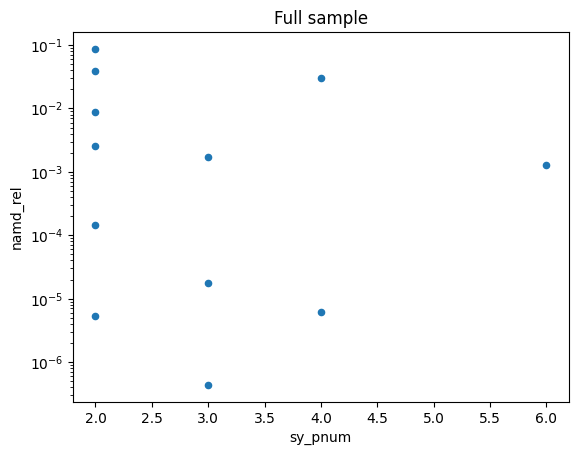

In [24]:
_ = (
    df.groupby("hostname")[["sy_pnum", "namd_rel"]]
    .mean()
    .reset_index()
    .plot(kind="scatter", x="sy_pnum", y="namd_rel", logy=True, title="Full sample")
)

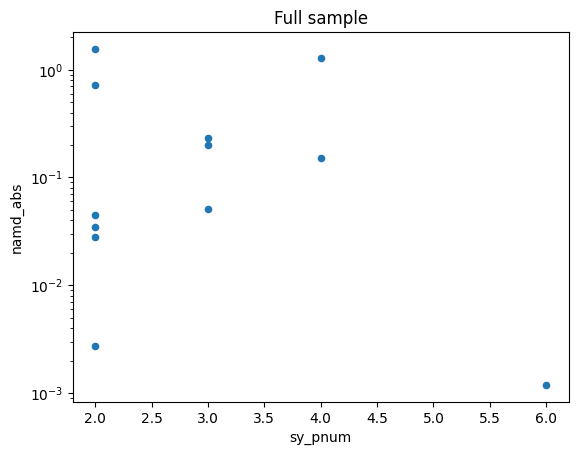

In [25]:
_ = (
    df.groupby("hostname")[["sy_pnum", "namd_abs"]]
    .mean()
    .reset_index()
    .plot(kind="scatter", x="sy_pnum", y="namd_abs", logy=True, title="Full sample")
)

### Task 9: computing the NAMD and associated confidence intervals


In [26]:
Npt = 200000
threshold = 1000

In [27]:
logger.info("Computing the Monte Carlo relative NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd_mc,
    kind="rel",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)
logger.info("Relative NAMD computed")

2024-10-12 22:56:11.085 | INFO     | __main__:<module>:1 - Computing the Monte Carlo relative NAMD


2024-10-12 22:56:12.591 | INFO     | __main__:<module>:11 - Relative NAMD computed


In [28]:
logger.info("Computing the Monte Carlo absolute NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd_mc,
    kind="abs",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)
logger.info("Absolute NAMD computed")

2024-10-12 22:56:12.661 | INFO     | __main__:<module>:1 - Computing the Monte Carlo absolute NAMD
2024-10-12 22:56:13.989 | INFO     | __main__:<module>:11 - Absolute NAMD computed


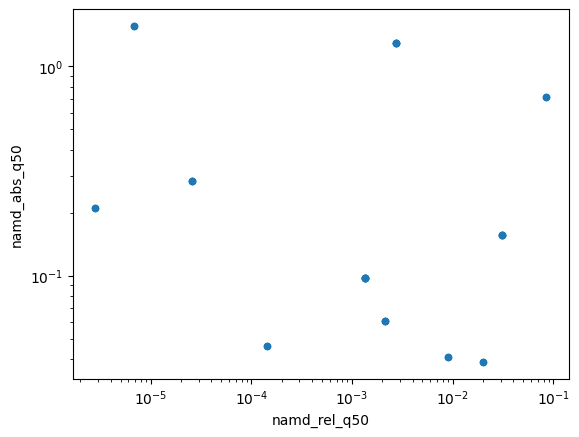

In [29]:
_ = (
    df.groupby("hostname")[["namd_rel_q50", "namd_abs_q50"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel_q50", y="namd_abs_q50", loglog=True)
)

In [30]:
logger.info("Storing the NAMD database")
out_path = os.path.join(ROOT, "data", "exo_namd_custom_db_20241012.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-10-12 22:56:14.448 | INFO     | __main__:<module>:1 - Storing the NAMD database
2024-10-12 22:56:14.454 | INFO     | __main__:<module>:4 - Database stored at /export/NAS/ariel/users/andrea.bocchieri/.local/lib/python3.10/site-packages/exonamd/data/exo_namd_custom_db_20241012.csv


In [31]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo_namd_custom_db_20241012.csv"))

### Some plots


2024-10-12 22:56:14.624 | INFO     | __main__:<module>:1 - Plotting the NAMD vs. multiplicity


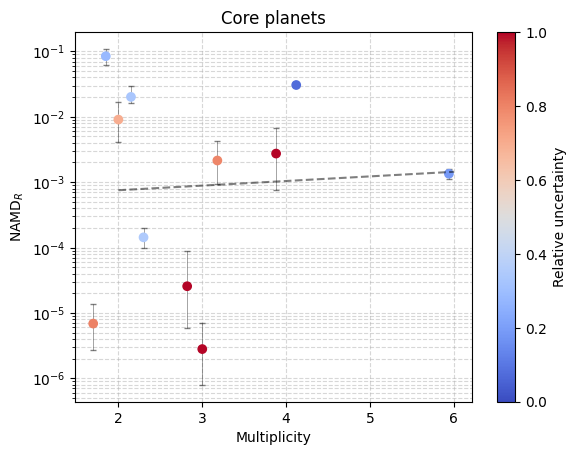

2024-10-12 22:56:15.023 | INFO     | __main__:<module>:12 - Plot done


In [32]:
logger.info("Plotting the NAMD vs. multiplicity")
pop_plot(
    df=df.groupby("hostname").apply(
        lambda g: g.select_dtypes(exclude=["object"]).mean(),
    ),
    kind="rel",
    title="Core planets",
    which="namd",
    yscale="log",
    xoffs=True,
)
logger.info("Plot done")

2024-10-12 22:56:15.139 | INFO     | __main__:<module>:1 - Plotting the NAMD vs. multiplicity


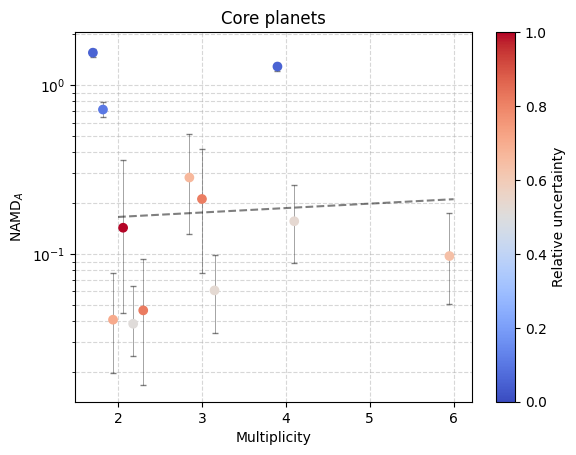

2024-10-12 22:56:15.411 | INFO     | __main__:<module>:12 - Plot done


In [33]:
logger.info("Plotting the NAMD vs. multiplicity")
pop_plot(
    df=df.groupby("hostname").apply(
        lambda g: g.select_dtypes(exclude=["object"]).mean(),
    ),
    kind="abs",
    title="Core planets",
    which="namd",
    yscale="log",
    xoffs=True,
)
logger.info("Plot done")

In [34]:
Npt = 10000000
threshold = 1000

2024-10-12 22:56:15.651 | INFO     | __main__:<module>:2 - Selecting the host: Kepler-462


2024-10-12 22:56:15.657 | INFO     | __main__:<module>:4 - Host selected
2024-10-12 22:56:15.658 | INFO     | __main__:<module>:6 - Computing the Monte Carlo relative NAMD
2024-10-12 22:56:20.054 | INFO     | __main__:<module>:14 - Values computed
2024-10-12 22:56:20.057 | INFO     | __main__:<module>:16 - Plotting the relative NAMD distribution


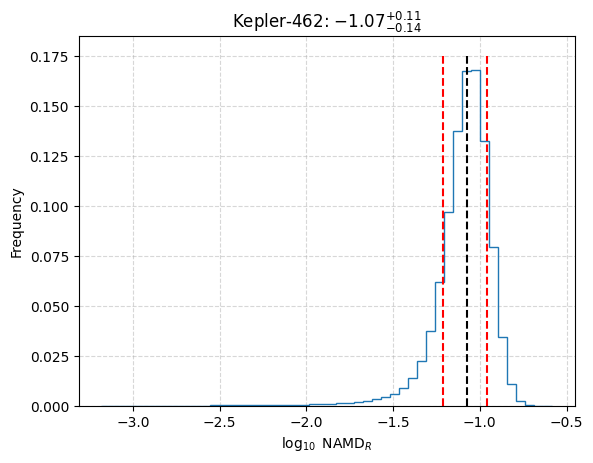

2024-10-12 22:56:20.406 | INFO     | __main__:<module>:24 - Plot done


In [35]:
hostname = "Kepler-462"
logger.info(f"Selecting the host: {hostname}")
host = df[df["hostname"] == hostname]
logger.info("Host selected")

logger.info("Computing the Monte Carlo relative NAMD")
retval = solve_namd_mc(
    host=host,
    kind="rel",
    Npt=Npt,
    threshold=threshold,
    full=True,
)
logger.info("Values computed")

logger.info("Plotting the relative NAMD distribution")
simple_plot(
    df=retval,
    kind="rel",
    title=hostname,
    which="namd",
    scale="log",
)
logger.info("Plot done")

2024-10-12 22:56:20.549 | INFO     | __main__:<module>:1 - Computing the Monte Carlo absolute NAMD
2024-10-12 22:56:24.148 | INFO     | __main__:<module>:9 - Values computed
2024-10-12 22:56:24.150 | INFO     | __main__:<module>:11 - Plotting the absolute NAMD distribution


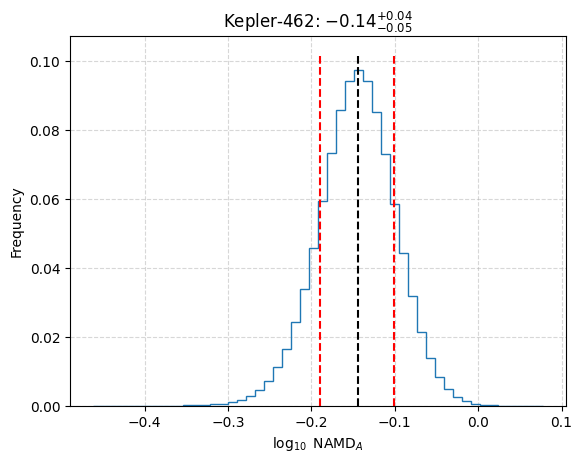

2024-10-12 22:56:24.644 | INFO     | __main__:<module>:19 - Plot done


In [36]:
logger.info("Computing the Monte Carlo absolute NAMD")
retval = solve_namd_mc(
    host=host,
    kind="abs",
    Npt=Npt,
    threshold=threshold,
    full=True,
)
logger.info("Values computed")

logger.info("Plotting the absolute NAMD distribution")
simple_plot(
    df=retval,
    kind="abs",
    title=hostname,
    which="namd",
    scale="log",
)
logger.info("Plot done")

TODO: 

1. check systems where the sy_pnum is different from the number of planets in the system reported in the exoplanet archive. e.g. XO-2 N
2. check compatibility with TepCat